# Chip making for a subset of GB

This document extracts a series of chips for a region of GB and stores them as `numpy` arrays ready to be loaded by TensorFlow.

In [2]:
import tools
import geopandas
import contextily
import xarray, rioxarray
from shapely.geometry import box

## Specs

In [3]:
specs = {
    'bb': box(321566, 365379, 468106, 437198),
    'chip_size': 64,
    'bands': [1, 2, 3], #RGB
    'mosaic_p': (
        '/home/jovyan/data/'
        'ghs_composite_s2/GHS-composite-S2.vrt'
    ),
    'spsig_p': (
        '/home/jovyan/data/spatial_signatures/'
        #'signatures/'
        'signatures_combined_levels_simplified.gpkg'
    )
}

## Load region

- Mosaic

In [4]:
r = rioxarray.open_rasterio(
    specs['mosaic_p'], chunks={'x': 1024, 'y': 1024}
)

- Region

In [5]:
region = r.sel(
    band=[1, 2, 3]
).rio.clip_box(
    *specs['bb'].bounds
).compute()

## Make chips

In [6]:
%%time
chips = tools.build_grid(
    region.coords['x'],
    region.coords['y'],
    specs['chip_size'],
    crs=region.rio.crs
)

CPU times: user 1.6 s, sys: 84.3 ms, total: 1.68 s
Wall time: 1.47 s


## Filter through signatures

- Read signature layer

In [7]:
spsig = geopandas.read_file(specs['spsig_p'])

- Join chips to signatures by `within` to keep only single-class chips

In [8]:
%%time
oc_chips = geopandas.sjoin(
    chips, 
    spsig[['signature_type', 'geometry']], 
    how='inner', 
    predicate='within'
)

CPU times: user 2.98 s, sys: 63.9 ms, total: 3.05 s
Wall time: 2.72 s


---

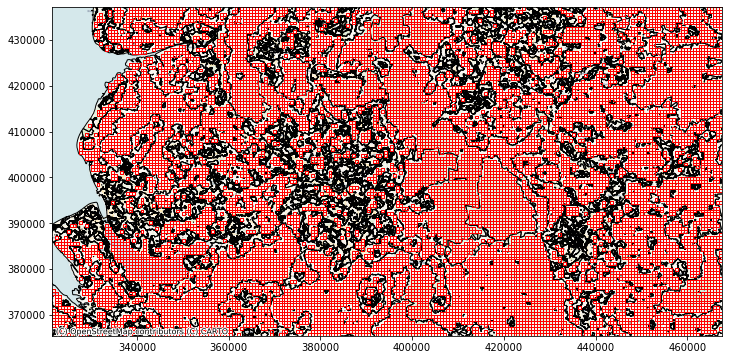

In [9]:
ax = spsig.plot(facecolor='none', edgecolor='k', figsize=(12, 12))
oc_chips.plot(facecolor='none', edgecolor='red', ax=ax)
minX, minY, maxX, maxY = oc_chips.total_bounds
ax.set_xlim((minX, maxX))
ax.set_ylim((minY, maxY))
contextily.add_basemap(
    ax, crs=oc_chips.crs, source=contextily.providers.CartoDB.Voyager
);

## Load imagery into chips

In [1]:
from dask.distributed import Client, LocalCluster
client = Client(
    LocalCluster(n_workers=16, threads_per_worker=1)
)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 16,Total memory: 62.49 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43605,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 62.49 GiB
Comm: tcp://172.17.0.2:40917,Total threads: 1
Dashboard: http://172.17.0.2:45729/status,Memory: 3.91 GiB
Nanny: tcp://127.0.0.1:45113,


In [9]:
%time out = tools.bag_of_chips(oc_chips, specs, 16)

CPU times: user 2.17 s, sys: 1.11 s, total: 3.29 s
Wall time: 5.72 s


In [15]:
%time out = tools.bag_of_chips(oc_chips, specs, 32)

CPU times: user 2.19 s, sys: 858 ms, total: 3.05 s
Wall time: 5.06 s


In [13]:
%time out2 = tools.chip_loader((oc_chips, specs))

CPU times: user 21.4 s, sys: 975 ms, total: 22.4 s
Wall time: 20.4 s


In [18]:
(out != out2).sum()

0

## Write to disk

Once ready, we store the array as a `.npz` file to be shipped to TensorFlow.

In [ ]:
# See https://numpy.org/doc/stable/reference/generated/numpy.savez_compressed.html